In [1]:
from dataset import CIFAR10
from utils import get_device, set_seed
from backprop import Train, Test

In [2]:
device = get_device()

Device Selected: mps


In [3]:
set_seed(device)

In [4]:
cifar10 = CIFAR10()

Files already downloaded and verified


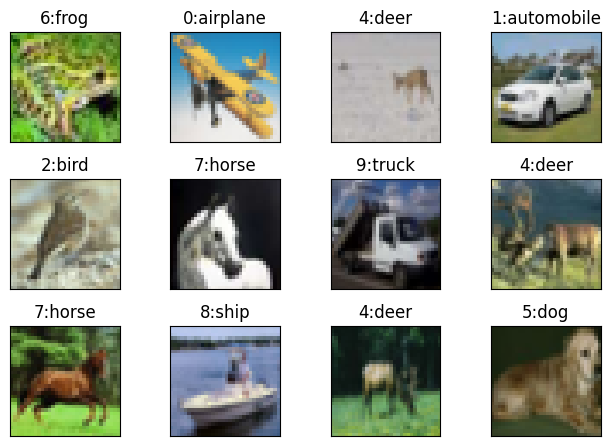

In [5]:
cifar10.show_examples()

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torchinfo


class BaseModel(nn.Module):
    def summary(self, input_size=None):
        return torchinfo.summary(
            self,
            input_size=input_size,
            col_names=["input_size", "output_size", "num_params", "params_percent"],
        )


class Model(BaseModel):
    def __init__(self):
        super(Model, self).__init__()
        self.cblock1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, bias=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, bias=False),
            nn.ReLU()
        )

        self.tblock1 = nn.Sequential(
            nn.Conv2d(64, 128, 1, bias=True),
            nn.MaxPool2d(2, 2)
        )

        self.cblock2 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.ReLU()
        )

        self.tblock2 = nn.Sequential(
            nn.Conv2d(128, 256, 1, bias=True),
            nn.MaxPool2d(2, 2)
        )

        self.cblock3 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.ReLU()
        )

        self.oblock = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(256, 10, 1),
            nn.Flatten(),
            nn.LogSoftmax(-1)
        )

    def forward(self, x):
        x = self.cblock1(x)
        x = self.tblock1(x)
        x += self.cblock2(x)
        x = self.tblock2(x)
        x += self.cblock3(x)
        x = self.oblock(x)
        return x

In [7]:
model=Model()

In [8]:
model.summary(input_size=(3, 32, 32))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %
Model                                    [3, 32, 32]               [10, 1]                   --                             --
├─Sequential: 1-1                        [3, 32, 32]               [64, 28, 28]              --                             --
│    └─Conv2d: 2-1                       [3, 32, 32]               [64, 30, 30]              1,728                       0.08%
│    └─ReLU: 2-2                         [64, 30, 30]              [64, 30, 30]              --                             --
│    └─Conv2d: 2-3                       [64, 30, 30]              [64, 28, 28]              36,864                      1.61%
│    └─ReLU: 2-4                         [64, 28, 28]              [64, 28, 28]              --                             --
├─Sequential: 1-2                        [64, 28, 28]              [128, 14, 14]             --                

In [9]:
train_loader, test_loader = cifar10.get_loaders()

Files already downloaded and verified


In [10]:
import torch.optim as optim
model = Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0, verbose=True, factor=0.5)

criterion = F.nll_loss
num_epochs = 20

train = Train(model, device, criterion, train_loader, optimizer)
test = Test(model, device, criterion, test_loader)

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train.run()
    test_loss = test.run()
    scheduler.step(test_loss)

Epoch 1


  0%|                                                                                                                                                                                                                | 0/1563 [00:13<?, ?it/s]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [MPSFloatType [32, 256, 7, 7]], which is output 0 of AddBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).